In [1]:
from dispatches_data.api import path
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import json
from static_surrogate_results.NE_case_study.analysis_annual_cf_NE import get_params, calculate_sweep_year_capacity_factor, make_dispatch_power_heatmap
from dispatches.workflow.train_market_surrogates.dynamic.Simulation_Data import SimulationData
from dispatches.workflow.train_market_surrogates.dynamic.Train_NN_Surrogates import TrainNNSurrogates
import keras

## Plot the capacity factors predicted by surrogates and sweep.

In [2]:
# plot sweep annual average capacity factors
case_type = 'NE'
surrogate_path_dict, sweep_param_dict = get_params(case_type)
sweep_year_cf = calculate_sweep_year_capacity_factor(sweep_param_dict)

In [3]:
# calculate surrogate annual cf

# data path
path_to_data_package = path("dynamic_sweep")
case_type = "NE"
dispatch_data_path = path_to_data_package / "NE" / "Dispatch_data_NE_Dispatch_whole.csv"
input_data_path = path_to_data_package / "NE" / "sweep_parameters_results_NE_whole.h5"
num_sims = 192

# NN path
model_path = pathlib.Path('NE_case_study', 'NE_30clusters_dispatch_frequency')
model_param_path = pathlib.Path('NE_case_study', 'NE_30clusters_dispatch_frequency_params.json')
with open(model_param_path) as f:
    NN_param = json.load(f)
NN_model = keras.models.load_model(model_path)
    
# work on reserve factor = 10, max_lmp = 500
simulation_data = SimulationData(dispatch_data_path, input_data_path, num_sims, case_type)
clustering_model_path = str(pathlib.Path('NE_case_study', f'NE_192years_30clusters_OD.json'))
NNtrainer = TrainNNSurrogates(simulation_data, clustering_model_path, filter_opt = True)
clustering_model = NNtrainer._read_clustering_model(clustering_model_path)
NNtrainer.model_type = "frequency"

x, ws = NNtrainer._transform_dict_to_array()
x_to_pred = x[0:48]

# scale data
xm = NN_param['xm_inputs']
xstd = NN_param['xstd_inputs']
wsm = NN_param['ws_mean']
wsstd = NN_param['ws_std']

x_scaled = (x_to_pred - xm)/xstd
pred_ws = NN_model.predict(x_scaled)
pred_ws_unscaled = pred_ws*wsstd + wsm

2/2 [==============================] - 0s 4ms/step


In [4]:
# calculate the surrogate predicted annual average cf
with open(clustering_model_path, 'r') as f:
    cluster_results = json.load(f)

# load the cluster centers
centers = cluster_results['model_params']['cluster_centers_']
pmax = 400

cf_surrogate = {}
for i in range(len(x_to_pred)):
    pmin = 400-x_to_pred[i][1]*400
    ws = pred_ws_unscaled[i]
    cf_surr = 0
    for j in range(len(centers)):
        day_cf = np.sum(centers[j])/24
        ws_j = ws[j+1]
        days = ws_j*366
        p_actual = (day_cf*(pmax-pmin)+pmin)
        cf_actual = p_actual/400
        cf_surr += cf_actual*ws_j
    zero_day_cf = pmin/400*ws[0]
    full_day_cf = 1*ws[-1]
    cf_surrogate[i] = cf_surr+zero_day_cf+full_day_cf

for i in range(48):
    print(sweep_year_cf[i], cf_surrogate[i])

0.9860988257063981 0.9821939517416547
0.9792990185684199 0.978000201437741
0.9577707182132285 0.957381211698777
0.9520872941339367 0.948174832814291
0.9515928489042577 0.9514216334217623
0.9515960837887067 0.9504276754246319
0.9726659388282672 0.970698847251974
0.9596535969259449 0.9584813234451862
0.9159598515050091 0.9160358383186918
0.9042676846951844 0.898585978381925
0.9037462392779486 0.9025417157479698
0.9036428223192737 0.903104080517453
0.9596421550839593 0.9595188679495
0.940326015776127 0.9399549058088119
0.8753248968610541 0.8757988714944068
0.8568265936125342 0.8500940613693256
0.8557164842062273 0.8540579545108332
0.8557202342161886 0.8557356340793392
0.9466076150506604 0.9483247273676637
0.9215431486199338 0.922145296294853
0.8348642456454918 0.8365844484951306
0.8098002872686132 0.8028028895375785
0.8079910671661544 0.8062530255559816
0.8077595437300774 0.8084498109975773
0.9345067579277665 0.9369138931004821
0.9036435113035063 0.9048679700417469
0.7961652289088115 0.79

In [36]:
def plot_contour(case_name, cf_dict):
    font1 = {
        'weight' : 'bold',
        'size'   : 16,
        }
    font2 = {
        'weight' : 'normal',
        'size'   : 15,
        }
    pem_ratio = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
    pem_bid = np.array([15,20,25,30,35,40])/20
    result_dict = {}
    rf_max_lmp_pair = [(10,500),(10,1000),(15,500),(15,1000)]
    c = 0

    ratio_array = np.zeros((len(pem_ratio),len(pem_bid)))
    for i in range(len(pem_ratio)):
        for j in range(len(pem_bid)):
#             r = surrogate_year_cf_dict[c]/sweep_dispatch_cf_dict[c]
            r = cf_dict[c]
            ratio_array[i][j] = r
            c += 1
            
    x,y = np.meshgrid(pem_ratio, pem_bid)

    fig, ax = plt.subplots(figsize =(8,6))


    # Rotate the tick labels and set their alignment.
    cs = ax.contour(x, y, ratio_array.T, levels = 10)
    ax.clabel(cs, inline=True, fontsize=10)
    # Loop over data dimensions and create text annotations.
#     for i in range(len(pem_ratio)):
#         for j in range(len(pem_bid)):
#             text = ax.text(i, j, np.round(result_dict[p][i, j],5),
#                             ha="center", va="center", color="r")

    ax.set_title(f"{case_name} NPP Capacity Factor", font=font1)
    ax.set_xlabel('PEM/NPP ratio', font=font1)
    ax.set_ylabel('H2 Price ($/kg)', font=font1)
    plt.xticks(font=font2)
    plt.yticks(font=font2)
#     fig.tight_layout()

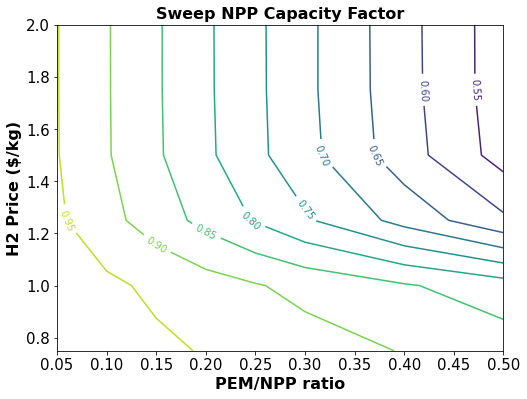

In [37]:
plot_contour("Sweep", sweep_year_cf)

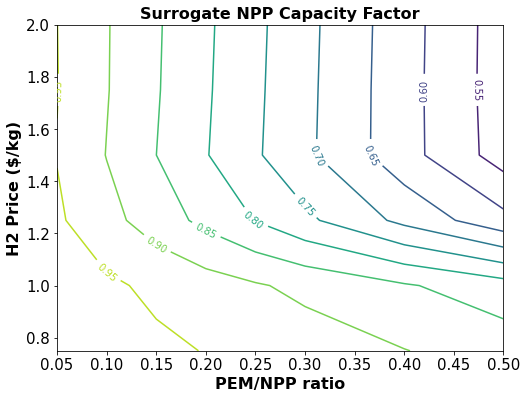

In [38]:
plot_contour("Surrogate", cf_surrogate)

## Surrogate results for different clusters of NE + PEM case (Kmeans)

### 15 + 2 clusters

In [3]:
R2 = [0.9988218096429256, 0.9820510404405077, 0.9364973669810126, 0.9854354950272489, 0.9962750477488229, 0.9880826604877762, 0.8163580875799334, 0.9880149029137892, 0.8168890610216468, 0.8686149479746388, 0.9725869320341666, 0.8741201394643557, 0.9604596654351042, 0.7630967834156203, 0.9926848592020125, 0.9900023787842864, 0.9845974613921067]
mean = np.mean(R2)
std = np.std(R2)
max_r2 = np.max(R2)
min_r2 = np.min(R2)

print(f"mean: {mean}")
print(f"std: {std}")
print(f"max: {max_r2}")
print(f"min: {min_r2}")

mean: 0.9361522729144679
std: 0.07465892816007529
max: 0.9988218096429256
min: 0.7630967834156203


### 20 + 2 clusters

In [5]:
R2 = [0.9987056565675754, 0.9443315987289274, 0.9409611353375675, 0.9771755271956724, 0.9867294621525903, 0.9884344129506749, 0.8619472097687928, 0.9745735747450436, 0.967759854161942, 0.9042880339483522, 0.9595118180742463, 0.8734126017443182, 0.9541348421875688, 0.9841318232970785, 0.9688658636015806, 0.9875126015310042, 0.994295654666191, 0.9672424172789358, 0.968001738023939, 0.9882885424265516, 0.9733297595909154, 0.989808484648519]
mean = np.mean(R2)
std = np.std(R2)
max_r2 = np.max(R2)
min_r2 = np.min(R2)

print(f"mean: {mean}")
print(f"std: {std}")
print(f"max: {max_r2}")
print(f"min: {min_r2}")

mean: 0.9615201187558177
std: 0.03628991475551788
max: 0.9987056565675754
min: 0.8619472097687928


### 25 + 2 clusters

In [6]:
R2 = [0.9982571380893076, 0.9842659297434192, 0.9265762164911038, 0.9916745895473489, 0.9522564705289314, 0.9541418020665976, 0.9485122126951309, 0.8713247062327876, 0.9801240366502383, 0.9874598126664972, 0.9671773670719787, 0.9698370265903028, 0.9801883940007267, 0.891222456829343, 0.966242142331458, 0.9813986445361591, 0.9827806774011472, 0.7557412085657689, 0.9816215795721418, 0.9623806932378586, 0.9595850536064459, 0.9792153668274923, 0.8165353882064095, 0.9822994692399626, 0.9327174399911086, 0.8523197264282573, 0.9908168885763549]
mean = np.mean(R2)
std = np.std(R2)
max_r2 = np.max(R2)
min_r2 = np.min(R2)

print(f"mean: {mean}")
print(f"std: {std}")
print(f"max: {max_r2}")
print(f"min: {min_r2}")

mean: 0.9461730532490472
std: 0.058212298365775995
max: 0.9982571380893076
min: 0.7557412085657689


### 30+2 clusters

In [10]:
R2 = [[0.9986938551806441, 0.9288186078862622, 0.962326567870176, 0.9575803936448753, 0.9658202579477188, 0.9802982374137188, 0.7865331039205169, 0.9856214162557654, 0.9301112104664598, 0.8150855113378775, 0.9767134408944463, 0.9909848812035035, 0.9448422373821367, 0.9067032715571343, 0.9751361590660393, 0.9820148496093654, 0.8958363423872158, 0.9897944980451718, 0.9763896121892334, 0.97716246188388, 0.6496689975196696, 0.9729753111475873, 0.9116208976854604, 0.9035566828556781, 0.8713570334675336, 0.860778466560547, 0.9839251160289156, 0.9671558696369076, 0.6811854540198801, 0.9043740656681507, 0.9476559362919775, 0.989114805305063]]
mean = np.mean(R2)
std = np.std(R2)
max_r2 = np.max(R2)
min_r2 = np.min(R2)

print(f"mean: {mean}")
print(f"std: {std}")
print(f"max: {max_r2}")
print(f"min: {min_r2}")

mean: 0.9240573610102972
std: 0.08422010194476921
max: 0.9986938551806441
min: 0.6496689975196696
